In [1]:
import sys
import os

project_root = os.path.abspath("..")
sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from config import *
from Data.raw_data_loader import (
    load_raw_crypto_csv,
    basic_data_diagnostics,
    check_constant_stretches,
)
from Models.pair_trading import build_spread, adf_test

plt.style.use("default")

In [2]:
df = load_raw_crypto_csv(DATA_PATH)

print("Data shape: ", df.shape)
print("Start:", df.index.min())
print("End:", df.index.max())

df.head()

Data shape:  (6612, 12)
Start: 2008-01-01 00:00:00
End: 2026-02-09 00:00:00


,BTC-USD_open,BTC-USD_high,BTC-USD_low,BTC-USD_close,BTC-USD_volume,BTC_REWARD,COST_TO_MINE,ETH-USD_open,ETH-USD_high,ETH-USD_low,ETH-USD_close,ETH-USD_volume
Date,,,,,,,,,,,,
2008-01-01,456.859985,456.859985,413.104004,424.440002,34483200.0,50.0,177.2767,314.690002,319.153015,298.513,307.907989,1.613480e+09
2008-01-02,456.859985,456.859985,413.104004,424.440002,34483200.0,50.0,177.2767,314.690002,319.153015,298.513,307.907989,1.613480e+09
2008-01-03,456.859985,456.859985,413.104004,424.440002,34483200.0,50.0,177.2767,314.690002,319.153015,298.513,307.907989,1.613480e+09
2008-01-04,456.859985,456.859985,413.104004,424.440002,34483200.0,50.0,177.2767,314.690002,319.153015,298.513,307.907989,1.613480e+09
2008-01-05,456.859985,456.859985,413.104004,424.440002,34483200.0,50.0,177.2767,314.690002,319.153015,298.513,307.907989,1.613480e+09


In [3]:
diagnostics = basic_data_diagnostics(df)
diagnostics

{'start_date': Timestamp('2008-01-01 00:00:00'),
 'end_date': Timestamp('2026-02-09 00:00:00'),
 'n_rows': 6612,
 'n_missing': np.int64(0),
 'btc_zero_volume_days': 0,
 'eth_zero_volume_days': 0,
 'duplicate_index': 0}

In [4]:
df0 = df.copy()

# Only keep rows where both assets exist and are positive
mask_positive = (df0["BTC-USD_close"] > 0) & (df0["ETH-USD_close"] > 0)
df0 = df0.loc[mask_positive].copy()

# Keep modern period where BTC/ETH both trade continuously
df0 = df0.loc["2016-01-01":].copy()

# Remove obvious bad ticks using return filters
btc_ret0 = df0["BTC-USD_close"].pct_change()
eth_ret0 = df0["ETH-USD_close"].pct_change()

btc_bad = btc_ret0.abs() > 1.0   # >100% day move very likely bad data
eth_bad = eth_ret0.abs() > 1.0   # ETH outlier guard (captures ETHA typo-like spikes)

df0 = df0.loc[~(btc_bad | eth_bad)].copy()

print("Filtered shape:", df0.shape)
print("Start:", df0.index.min(), "End:", df0.index.max())


Filtered shape: (3690, 12)
Start: 2016-01-01 00:00:00 End: 2026-02-09 00:00:00


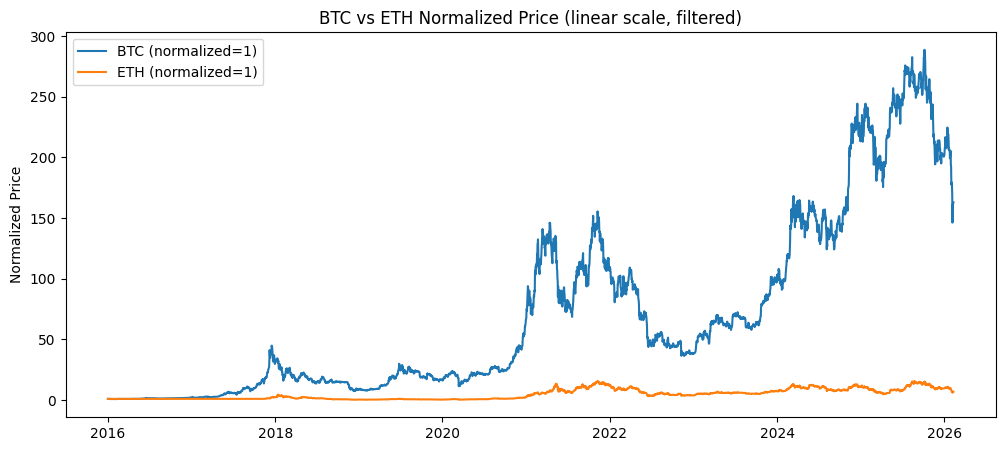

In [5]:
norm = (df0[["BTC-USD_close", "ETH-USD_close"]] / df0[["BTC-USD_close", "ETH-USD_close"]].iloc[0])

plt.figure(figsize=(12,5))
plt.plot(norm.index, norm["BTC-USD_close"], label="BTC (normalized=1)")
plt.plot(norm.index, norm["ETH-USD_close"], label="ETH (normalized=1)")
plt.title("BTC vs ETH Normalized Price (linear scale, filtered)")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()


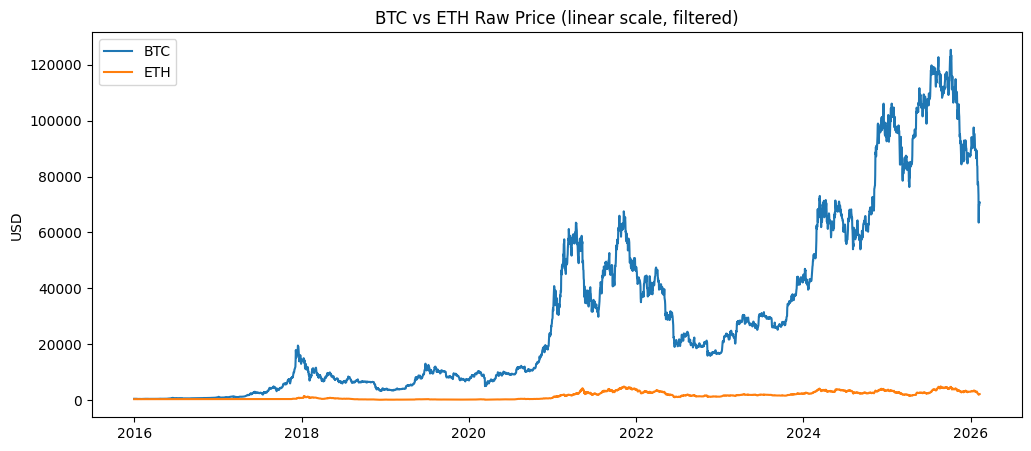

In [6]:
plt.figure(figsize=(12,5))
plt.plot(df0.index, df0["BTC-USD_close"], label="BTC")
plt.plot(df0.index, df0["ETH-USD_close"], label="ETH")
plt.title("BTC vs ETH Raw Price (linear scale, filtered)")
plt.ylabel("USD")
plt.legend()
plt.show()


In [7]:
btc_ret = df0["BTC-USD_close"].pct_change().dropna()
eth_ret = df0["ETH-USD_close"].pct_change().dropna()

print("BTC annualized vol:", float(btc_ret.std() * np.sqrt(365)))
print("ETH annualized vol:", float(eth_ret.std() * np.sqrt(365)))

corr = float(btc_ret.corr(eth_ret))
print("BTC–ETH daily return correlation:", corr)

BTC annualized vol: 0.6700156610477671
ETH annualized vol: 0.8018998563139621
BTC–ETH daily return correlation: 0.6878041721630858


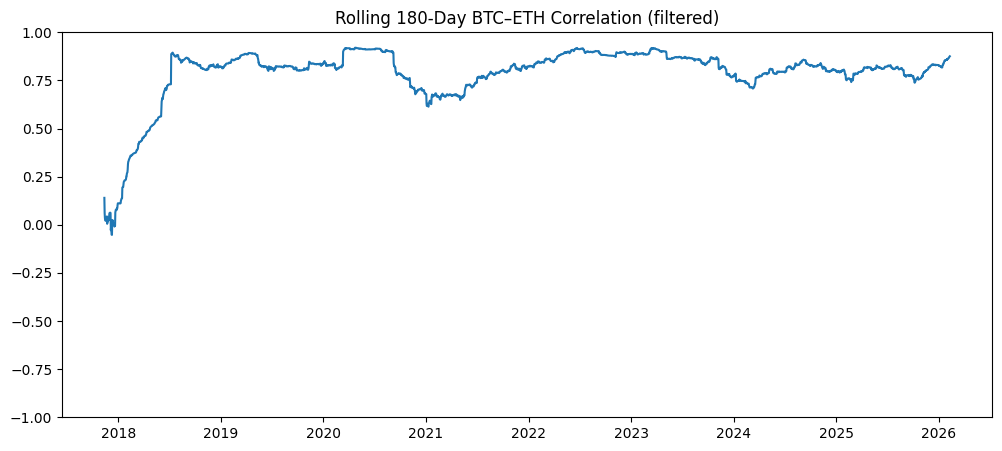

In [8]:
rolling_corr = btc_ret.rolling(180).corr(eth_ret)

plt.figure(figsize=(12,5))
plt.plot(rolling_corr.index, rolling_corr)
plt.ylim(-1, 1)
plt.title("Rolling 180-Day BTC–ETH Correlation (filtered)")
plt.show()

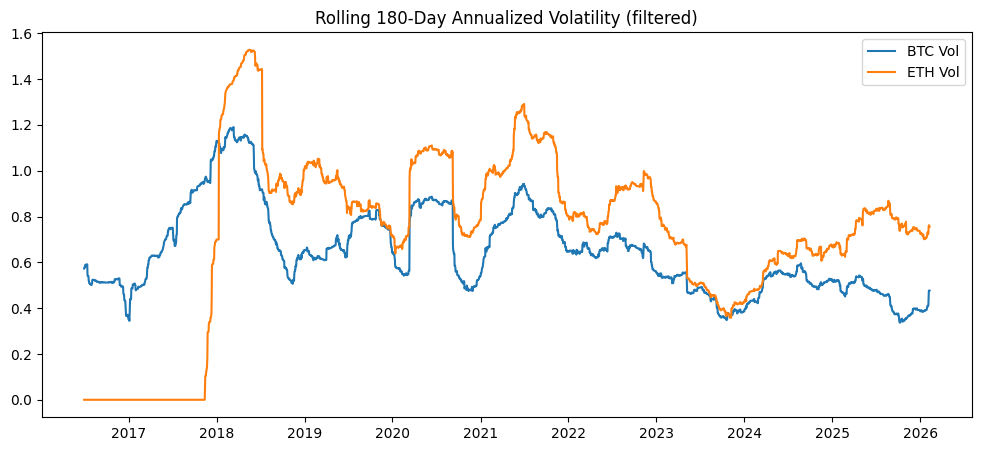

In [9]:
btc_vol = btc_ret.rolling(180).std() * np.sqrt(365)
eth_vol = eth_ret.rolling(180).std() * np.sqrt(365)

plt.figure(figsize=(12,5))
plt.plot(btc_vol.index, btc_vol, label="BTC Vol")
plt.plot(eth_vol.index, eth_vol, label="ETH Vol")
plt.title("Rolling 180-Day Annualized Volatility (filtered)")
plt.legend()
plt.show()

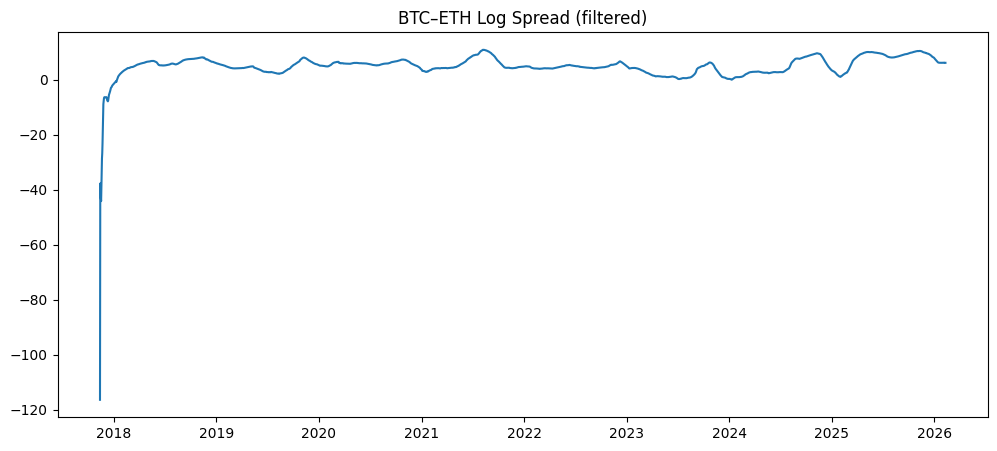

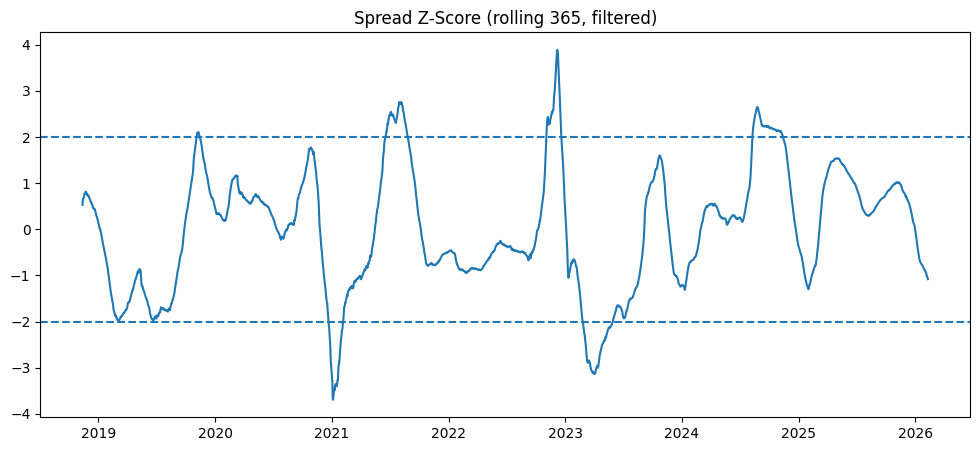

{'ADF_stat': -4.5801947242210606,
 'p_value': 0.00014047354286518557,
 'n_lags': 29,
 'n_obs': 2978}

In [10]:
from Models.pair_trading import build_spread, adf_test

spread = build_spread(df0, window=PAIR_BETA_WINDOW)

plt.figure(figsize=(12,5))
plt.plot(spread.index, spread)
plt.title("BTC–ETH Log Spread (filtered)")
plt.show()

spread_z = (spread - spread.rolling(365).mean()) / spread.rolling(365).std()

plt.figure(figsize=(12,5))
plt.plot(spread_z.index, spread_z)
plt.axhline(2, linestyle="--")
plt.axhline(-2, linestyle="--")
plt.title("Spread Z-Score (rolling 365, filtered)")
plt.show()

adf_results = adf_test(spread.dropna())
adf_results